---

This notebook contains code to re-create **Figure 4** from:

*Gaussian Process Modeling to Recover Faraday Depth Spectra*, 2020, Simon W. Ndiritu, Anna M. M. Scaife, D. Tabb, Miguel Carcamo & Joe Hanson

**Note:** The flagging and noise realisations implemented in this notebook are stochastic, so the figure will have the same properties as the one that appears in the paper but is unlikely to be identical.

---

In [1]:
import autograd.numpy as np
import pylab as pl
import os,sys
import itertools

In [2]:
from celerite_base import *

In [3]:
pl.rcParams['figure.figsize'] = [10, 5]
pl.rcParams['figure.dpi'] = 300

---
### Create data

In [4]:
def make_scenario1(phi_gal, l2):
    
    p0 = 1.0
    alpha = 0.7
    nu0 = 1.4e9
    nu = 3e8/np.sqrt(l2)
    k = (nu/nu0)**(-1*alpha)
    mu_q = p0*k*np.cos(2.*phi_gal*l2)
    mu_u = p0*k*np.sin(2.*phi_gal*l2)
    
    p = np.mean(np.sqrt(mu_q**2+mu_u**2))
    
    return mu_q, mu_u

In [5]:
const_c = 3e8    # speed of light

nu_min = 0.58e9  # minimum frequency
nu_max = 2.50e9  # maximum frequency

nu = np.linspace(nu_min, nu_max, 512)  # make data regularly spaced in frequency:
l2 = (const_c/nu)**2                   # convert frequencies to lambda^2

In [6]:
phi_gal = 50.
stokesQ, stokesU = make_scenario1(phi_gal, l2)

In [7]:
noise = 1.0
stokesQn=stokesQ + np.random.normal(loc =0.0, scale=noise, size = len(stokesQ))
stokesUn=stokesU + np.random.normal(loc =0.0, scale=noise, size = len(stokesU))

---
### Flag data

In [8]:
remove_frac = 0.3

In [9]:
_chansremoved = []
while True:
    pos = np.random.randint(0,len(nu))  # get position
    width = np.random.uniform(0,100)  # get chunk size
    low = int(pos - 0.5*width)
    if low<0: low = 0
    high= int(pos + 0.5*width)
    if high>=len(nu): high = len(nu)-1
    
    _chansremoved.append(list(np.arange(low,high)))
    merged = list(itertools.chain(*_chansremoved))
    
    chans_removed = np.unique(np.ravel(np.array(merged)))
    frac = float(len(chans_removed))/float(len(nu))
    if frac > remove_frac: break
        
# adjust back towards specified fraction
# using single channel adjustments:
while True:
    idx = np.random.randint(0,len(chans_removed))
    chans_removed = np.delete(chans_removed, idx)
    frac = float(len(chans_removed))/float(len(nu))
    if frac<=remove_frac: break
   
print("Fraction removed: ",frac)

('Fraction removed: ', 0.298828125)


Make mask to separate flagged channels:

In [10]:
mask = np.zeros(len(nu), dtype=bool)
mask[chans_removed] = 1

Specify flagged (missing) data points:

In [11]:
l2m = l2[mask]
stokesQm = stokesQn[mask]
stokesUm = stokesUn[mask]

Specify unflagged (present) data points:

In [12]:
l2 = l2[~mask]
stokesQn = stokesQn[~mask]
stokesUn = stokesUn[~mask]

---
### Fit data

Optimise the hyper-parameters:

In [13]:
GP = MyCelerite()
GP.celerite_optimize(l2, stokesQn, stokesUn)

Predict the Q and U data at regularly spaced $\lambda^2$ intervals:

In [14]:
t1 = np.linspace(np.min(l2), np.max(l2), 512)
mu_q, std_q, mu_u, std_u = GP.celerite_predict(stokesQn, stokesUn, t1)

Make a quick plot to check the output:

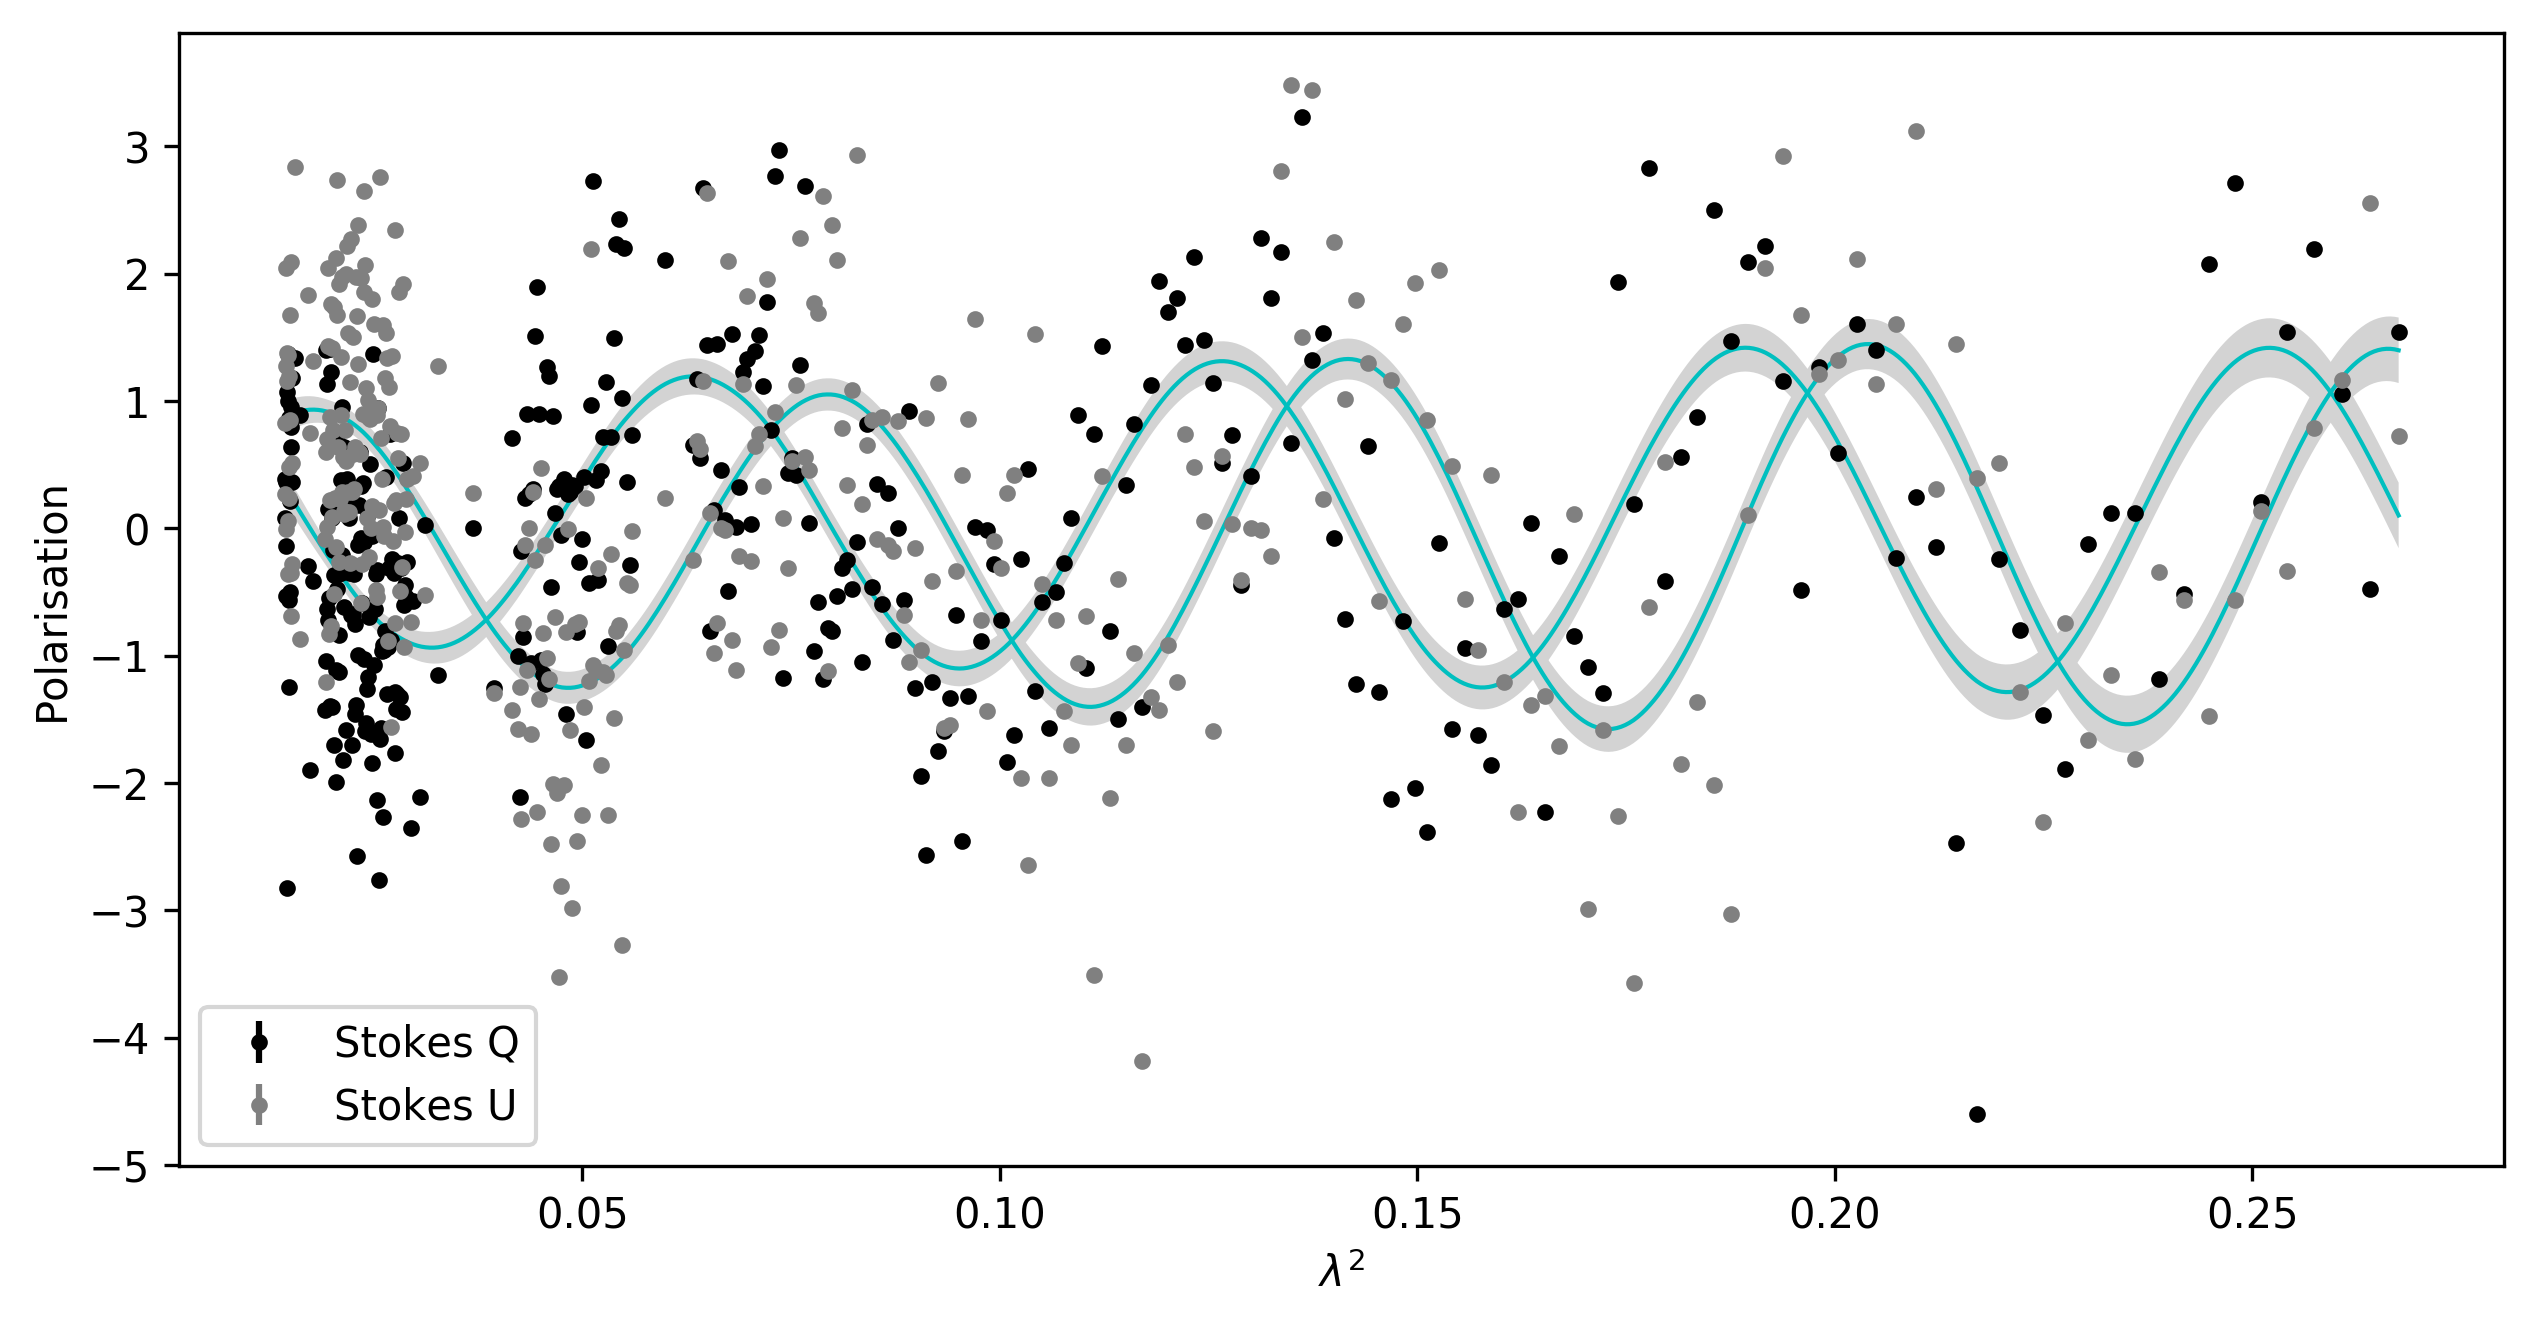

In [15]:
ax = pl.subplot(111)

ax.plot(t1, mu_q, linestyle='-', color = 'c', lw=1.0)
ax.plot(t1, mu_u, linestyle='-', color = 'c', lw=1.0)

ax.fill_between(t1, mu_q-std_q, mu_q+std_q, facecolor='lightgray')
ax.fill_between(t1, mu_u-std_u, mu_u+std_u, facecolor='lightgray')

ax.errorbar(l2[::-1],stokesQn[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax.errorbar(l2[::-1],stokesUn[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax.set_ylabel("Polarisation")
ax.set_xlabel(r"$\lambda^2$")

ax.legend()
pl.show()

Extract the MCMC samples for the periodicity:

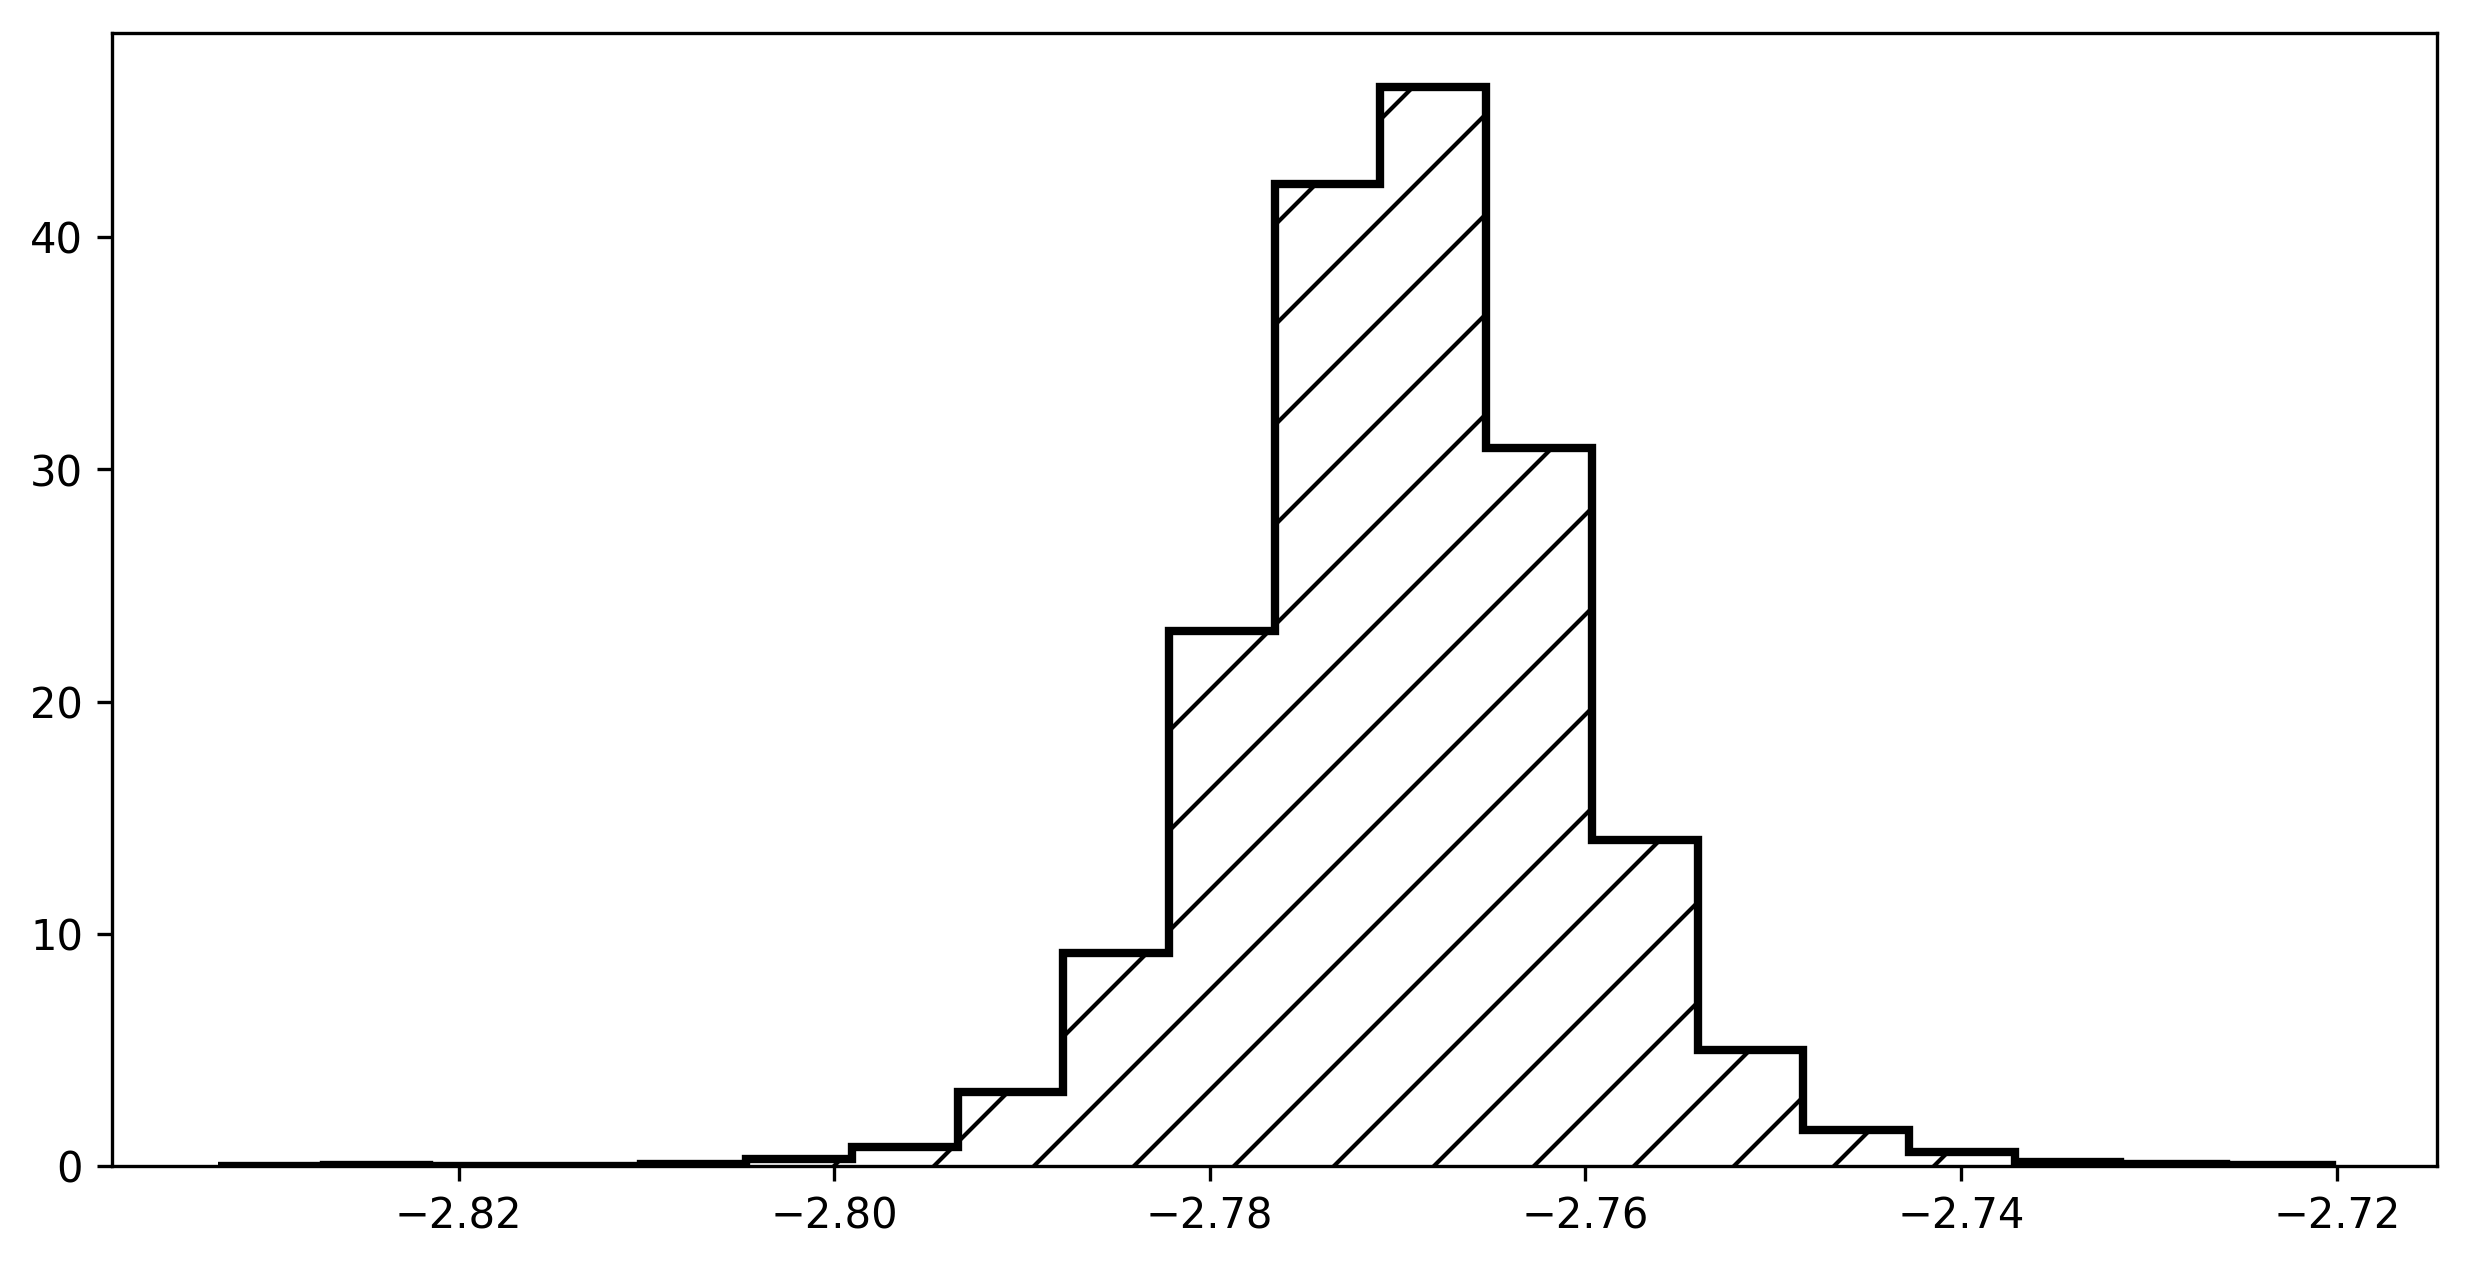

In [16]:
ndim=4
samples = GP.sampler.chain[:, 100:, :].reshape((-1, ndim))
n, bins, patches = pl.hist(samples[:,2], 20, density=True, histtype='step', linewidth=2, facecolor='none', hatch='/', edgecolor='k',fill=True)

---
### Make plot

Create predictions at the positions of the unflagged and flagged data points:

In [17]:
l2_qn, _, _, _ = GP.celerite_predict(stokesQn, stokesUn, l2[::-1])
l2_qm, _, _, _ = GP.celerite_predict(stokesQn, stokesUn, l2m[::-1])

Find the residuals between the predictions and the data:

In [18]:
diff_q  = (stokesQn[::-1] - l2_qn)/noise
diff_qm = (stokesQm[::-1] - l2_qm)/noise

Make the plot:

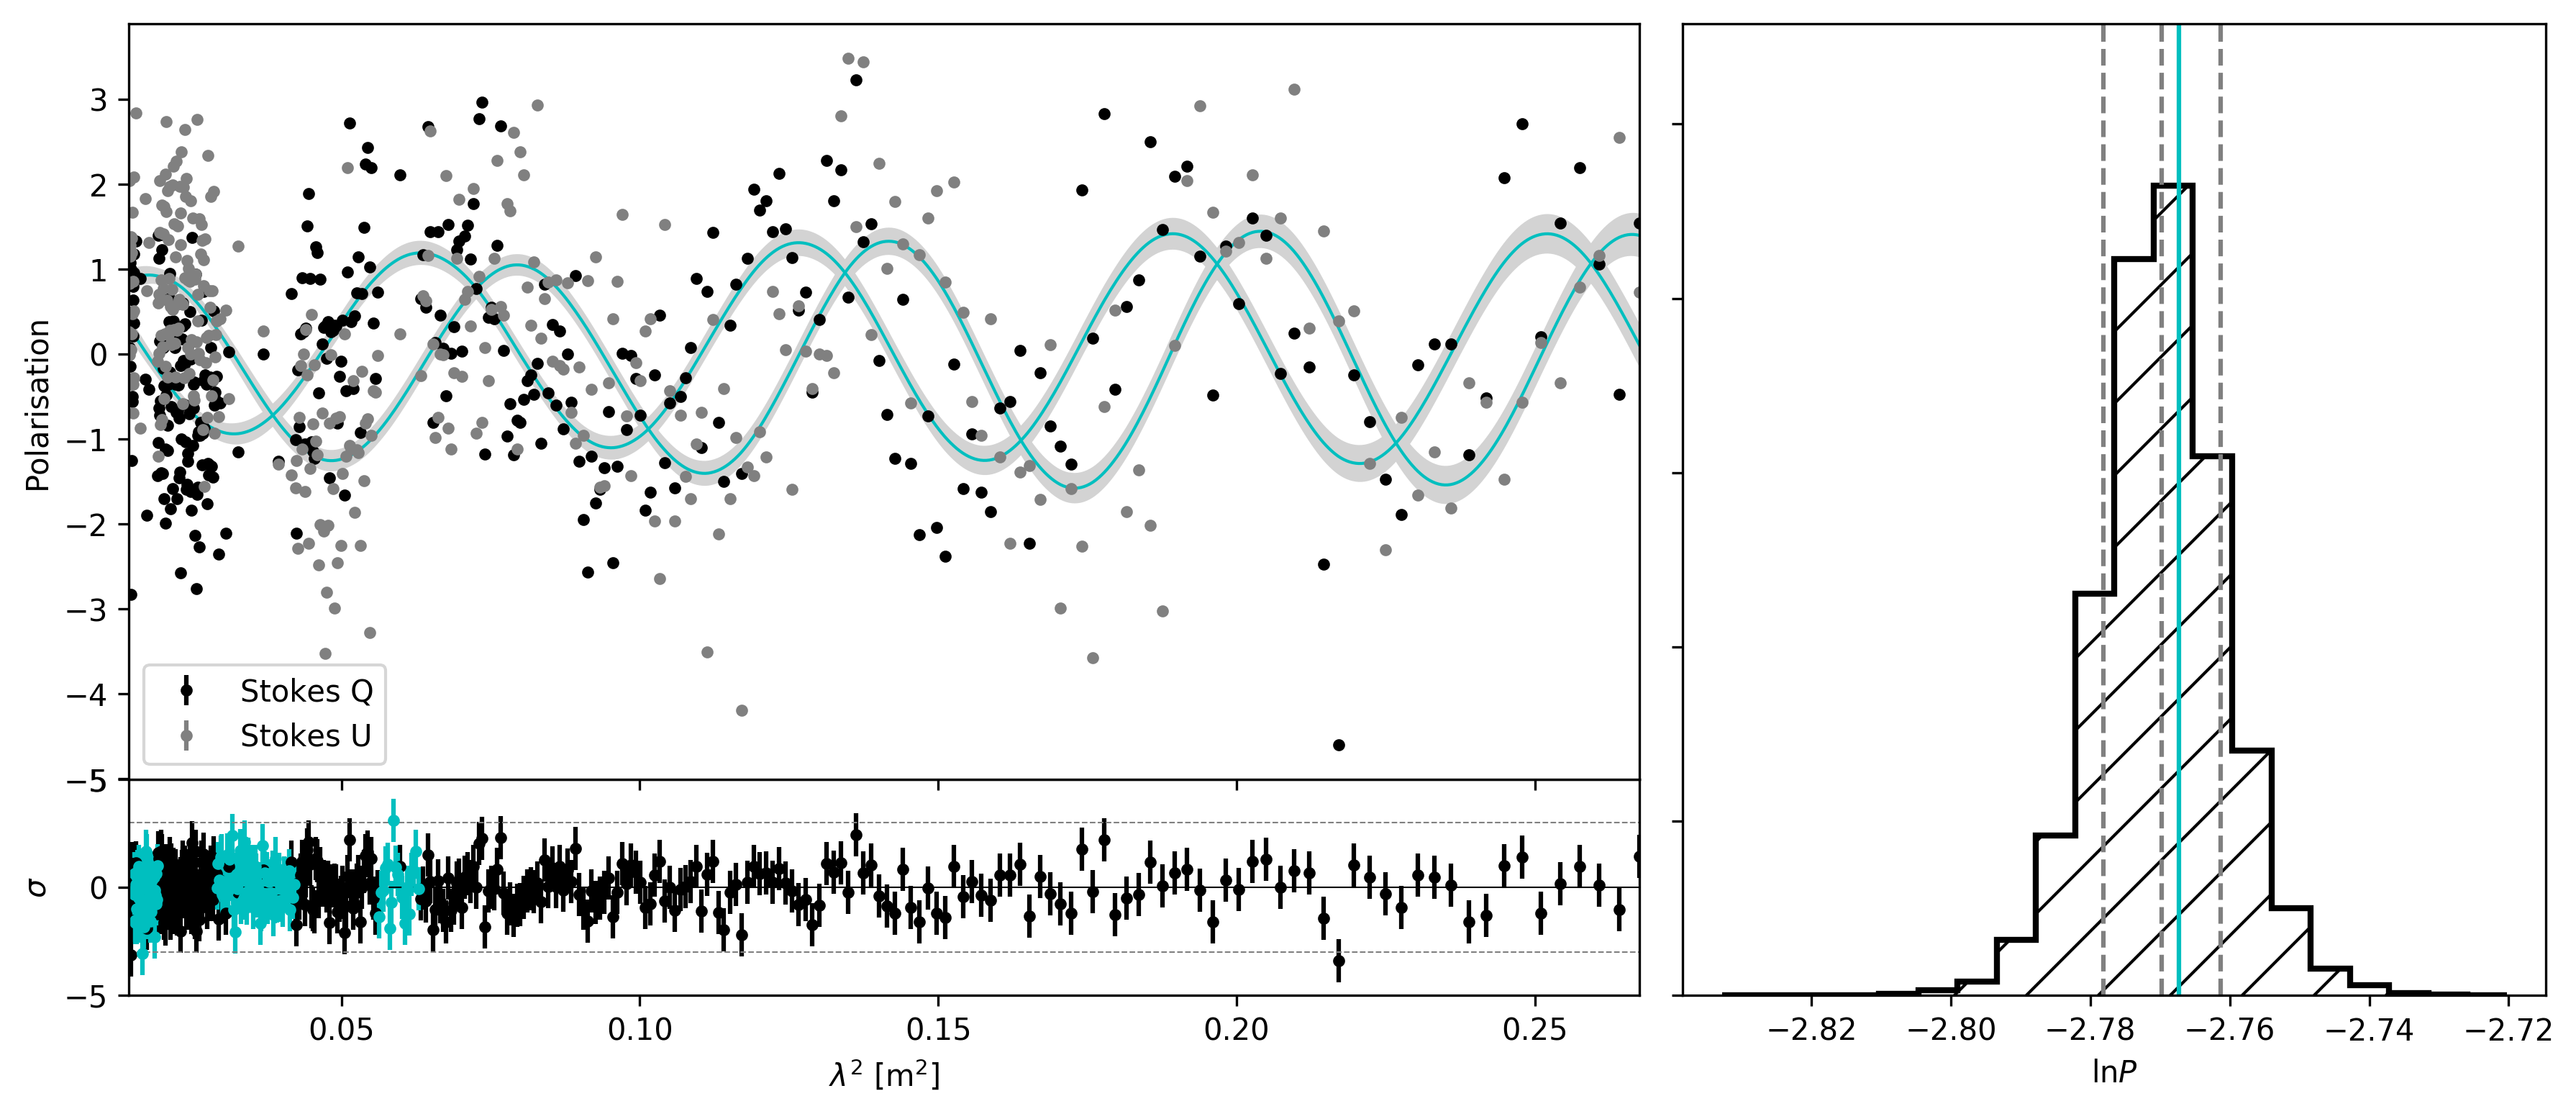

In [19]:
fig = pl.figure()

# ----------

ax1 = fig.add_axes([0.1, 0.1, 0.7, 0.2], ylim=(-5, 5), xlim=(np.min(l2),np.max(l2)))

ax1.errorbar(l2[::-1],diff_q, yerr=1.0, fmt='.', c='black', capthick=0)
ax1.errorbar(l2m[::-1],diff_qm, yerr=1.0, fmt='.', c='c', capthick=0)


ax1.plot([np.min(l2),np.max(l2)],[3,3],ls='--',c='grey',lw=0.5)
ax1.plot([np.min(l2),np.max(l2)],[0,0],ls='-',c='black',lw=0.5)
ax1.plot([np.min(l2),np.max(l2)],[-3,-3],ls='--',c='grey',lw=0.5)

ax1.set_ylabel(r"$\sigma$")
ax1.set_xlabel(r"$\lambda^2$ [m$^2$]")

# ----------

ax2 = fig.add_axes([0.1, 0.3, 0.7, 0.7], xticklabels=[], xlim=(np.min(l2),np.max(l2)))

ax2.plot(t1,mu_q, linestyle='-', color = 'c', lw=1.0)
ax2.plot(t1,mu_u, linestyle='-', color = 'c', lw=1.0)

ax2.fill_between(t1,mu_q-std_q,mu_q+std_q, facecolor='lightgray')
ax2.fill_between(t1,mu_u-std_u,mu_u+std_u, facecolor='lightgray')

ax2.errorbar(l2[::-1],stokesQn[::-1], yerr=0., fmt='.', c='black', capthick=0, label="Stokes Q")
ax2.errorbar(l2[::-1],stokesUn[::-1], yerr=0., fmt='.', c='grey', capthick=0, label="Stokes U")

ax2.set_ylabel("Polarisation")

ax2.legend()

# ----------

peak = 1.2*np.max(n)
ax3 = fig.add_axes([0.82, 0.1, 0.4, 0.9],yticklabels=[],ylim=(0,peak))

n, bins, patches = ax3.hist(samples[:,2], 20, density=True, histtype='step', linewidth=2, facecolor='none', hatch='/', edgecolor='k',fill=True)
p1 = np.percentile(samples[:,2], 16)
ax3.plot([p1,p1],[0,peak],ls='--',c='grey')
p2 = np.percentile(samples[:,2], 50)
ax3.plot([p2,p2],[0,peak],ls='--',c='grey')
p3 = np.percentile(samples[:,2], 84)
ax3.plot([p3,p3],[0,peak],ls='--',c='grey')

p0 = np.log(np.pi/50.)
ax3.plot([p0,p0],[0,peak],ls='-',c='c')
ax3.set_xlabel(r"$\ln P$")
# ----------

pl.show()